In [1]:
!pip install transformers datasets sentencepiece
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install bitsandbytes



Looking in indexes: https://download.pytorch.org/whl/cu121


In [2]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Trainer, TrainingArguments

!ls -lh final_data/en-te/train.*


-rw-r--r-- 1 pammiabhishikth pammiabhishikth 257M Apr 14  2021 final_data/en-te/train.en
-rw-r--r-- 1 pammiabhishikth pammiabhishikth 716M Apr 14  2021 final_data/en-te/train.te


In [3]:
with open("final_data/en-te/train.en", "r", encoding="utf-8") as f:
    en_lines = f.readlines()

with open("final_data/en-te/train.te", "r", encoding="utf-8") as f:
    te_lines = f.readlines()

print(f"{len(en_lines)} sentence pairs loaded")
print("Example:", en_lines[0].strip(), "→", te_lines[0].strip())

print("en lines:", len(en_lines))
print("te lines:", len(te_lines))


4841862 sentence pairs loaded
Example: Rise again. → మళ్లీ ఉదయిస్తాడు.
en lines: 4841862
te lines: 4841862


In [4]:
with open("train.en", "r", encoding="utf-8") as f_en, open("train.te", "r", encoding="utf-8") as f_te, open("train.en-te.tsv", "w", encoding="utf-8") as f_out:
    for en, te in zip(f_en, f_te):
        f_out.write(f"en\t{en.strip()}\tte\t{te.strip()}\n")


In [5]:
import torch
print(torch.__version__)
print("Torch:", torch.__file__)

import transformers
print("Transformers:", transformers.__file__)


2.5.1+cu121
Torch: /home/pammiabhishikth/jupyter_env/lib/python3.11/site-packages/torch/__init__.py
Transformers: /home/pammiabhishikth/jupyter_env/lib/python3.11/site-packages/transformers/__init__.py


In [6]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

model_name = "ai4bharat/indictrans2-en-indic-dist-200M"

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    torch_dtype=torch.float16  # Use float16 for reduced memory usage
).to("cuda")  # Move model to GPU if available


In [7]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=1,         # Smallest to avoid OOM
    gradient_accumulation_steps=1,         # Lowered from 4 to reduce memory
    num_train_epochs=1,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="no",
    bf16=False,
    fp16=False,
    report_to="none",
    optim="adamw_torch_fused",  # Slightly faster and may use less memory
    learning_rate = 2e-6,
    max_grad_norm=1.0,

)


In [8]:
from datasets import load_dataset

# Load your TSV file
raw_dataset = load_dataset(
    "csv",
    data_files={"train": "train.en-te.tsv"},
    delimiter="\t",
    column_names=["lang1", "en", "lang2", "te"]
)

#  Shuffle and take a random 15,000-sample subset
raw_dataset["train"] = raw_dataset["train"].shuffle(seed=42).select(range(15000))

#  Tokenization using text_target (not deprecated)
def preprocess_function(examples):
    inputs = examples["en"]
    targets = examples["te"]
    
    #  Shortened max_length for speed and memory efficiency
    model_inputs = tokenizer(inputs, max_length=32, truncation=True)
    labels = tokenizer(text_target=targets, max_length=32, truncation=True)
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

#  In-memory tokenization to avoid disk overhead
tokenized_dataset = raw_dataset["train"].map(
    preprocess_function,
    batched=True,
    keep_in_memory=True
)


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

In [9]:
from transformers import DataCollatorForSeq2Seq, Seq2SeqTrainer

# Enable memory-saving mode
model.gradient_checkpointing_enable()

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)


You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.
/tmp/ipykernel_7581/3205790203.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [10]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:32,expandable_segments:True"



In [11]:
import torch
# clear any leftover memory

trainer.train()


/home/pammiabhishikth/jupyter_env/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss
10,10.399600
20,6.530900
30,5.599200
40,4.495100
50,4.040800
60,3.775800
70,3.992600
80,4.060000
90,4.203100
100,4.273800


TrainOutput(global_step=15000, training_loss=2.7326329427083333, metrics={'train_runtime': 3081.2822, 'train_samples_per_second': 4.868, 'train_steps_per_second': 4.868, 'total_flos': 147700009476096.0, 'train_loss': 2.7326329427083333, 'epoch': 1.0})

In [12]:
model_dir = "./indictrans2-en-te-finetuned"
trainer.save_model(model_dir)
tokenizer.save_pretrained(model_dir)


('./indictrans2-en-te-finetuned/tokenizer_config.json',
 './indictrans2-en-te-finetuned/special_tokens_map.json',
 './indictrans2-en-te-finetuned/dict.SRC.json',
 './indictrans2-en-te-finetuned/dict.TGT.json',
 './indictrans2-en-te-finetuned/model.SRC',
 './indictrans2-en-te-finetuned/model.TGT',
 './indictrans2-en-te-finetuned/added_tokens.json')

In [13]:
import sys
sys.path.append("./indictrans2-en-te-finetuned")

from tokenization_indictrans import IndicTransTokenizer
from transformers import AutoModelForSeq2SeqLM

# Load tokenizer
tokenizer = IndicTransTokenizer(
    src_vocab_fp="./indictrans2-en-te-finetuned/dict.SRC.json",
    tgt_vocab_fp="./indictrans2-en-te-finetuned/dict.TGT.json",
    src_spm_fp="./indictrans2-en-te-finetuned/model.SRC",
    tgt_spm_fp="./indictrans2-en-te-finetuned/model.TGT",
    do_lower_case=True,
    bos_token="<s>",
    eos_token="</s>",
    pad_token="<pad>",
    unk_token="<unk>"
)

# Load model
model = AutoModelForSeq2SeqLM.from_pretrained("./indictrans2-en-te-finetuned")


The repository for ./indictrans2-en-te-finetuned contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/./indictrans2-en-te-finetuned.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


In [14]:
# Load full dataset again for eval selection
full_eval_data = load_dataset(
    "csv",
    data_files={"train": "train.en-te.tsv"},
    delimiter="\t",
    column_names=["lang1", "en", "lang2", "te"]
)

# Shuffle and select 2,100 rows for evaluation
eval_dataset_raw = full_eval_data["train"].shuffle(seed=42).select(range(3000))


In [15]:
tokenized_eval_dataset = eval_dataset_raw.map(
    preprocess_function,
    batched=True,
    keep_in_memory=True
)


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [16]:
tokenized_eval_dataset.save_to_disk("tokenized_eval_dataset_en_te")

Saving the dataset (0/1 shards):   0%|          | 0/3000 [00:00<?, ? examples/s]

In [17]:
eval_results = trainer.evaluate(eval_dataset=tokenized_eval_dataset)
print(eval_results)


{'eval_loss': 2.462890625, 'eval_runtime': 12.6054, 'eval_samples_per_second': 237.993, 'eval_steps_per_second': 29.749, 'epoch': 1.0}


In [18]:
!pip install evaluate


In [19]:
!wget https://huggingface.co/ai4bharat/indictrans2-en-indic-dist-200M/resolve/main/tokenization_indictrans.py -P ./en-te-finetuned


--2025-04-19 23:05:38--  https://huggingface.co/ai4bharat/indictrans2-en-indic-dist-200M/resolve/main/tokenization_indictrans.py
Resolving huggingface.co (huggingface.co)... 108.158.173.50, 108.158.173.9, 108.158.173.37, ...
Connecting to huggingface.co (huggingface.co)|108.158.173.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8129 (7.9K) [text/plain]
Saving to: ‘./en-te-finetuned/tokenization_indictrans.py.1’

tokenization_indict 100%[===================>]   7.94K  --.-KB/s    in 0s      

2025-04-19 23:05:39 (139 MB/s) - ‘./en-te-finetuned/tokenization_indictrans.py.1’ saved [8129/8129]



In [20]:
import evaluate
import torch

# Load BLEU metric
metric = evaluate.load("sacrebleu")

# Use a small subset (only 10 to test stability first)
subset = tokenized_eval_dataset.select(range(10))

predictions_output = trainer.predict(subset)

# Extract predictions and labels correctlym 
pred_token_ids = predictions_output.predictions  # <- this is what you want
label_token_ids = predictions_output.label_ids


In [21]:
import numpy as np
import evaluate

def compute_bleu_score(trainer, tokenizer, dataset, num_samples=10):
    subset = dataset.select(range(num_samples))
    output = trainer.predict(subset)

    # Convert logits to token IDs
    logits = output.predictions
    if isinstance(logits, tuple):
        logits = logits[0]
    pred_token_ids = np.argmax(logits, axis=-1)

    label_token_ids = output.label_ids

    # Decode predictions
    decoded_preds = tokenizer.batch_decode(pred_token_ids, skip_special_tokens=True)

    # Replace -100 with pad_token_id
    label_token_ids = [
        [(l if l != -100 else tokenizer.pad_token_id) for l in label]
        for label in label_token_ids
    ]
    decoded_labels = tokenizer.batch_decode(label_token_ids, skip_special_tokens=True)

    # Compute BLEU score
    metric = evaluate.load("sacrebleu")
    result = metric.compute(
        predictions=decoded_preds,
        references=[[ref] for ref in decoded_labels]
    )

    print(f" BLEU score: {result['score']:.2f}")
    return result['score']


In [23]:
for seq in pred_token_ids:
    for tok in seq:
        print(type(tok), tok, getattr(tok, 'shape', None))
    break


<class 'numpy.ndarray'> [[-3.732 -3.732  2.426 ... -3.732 -3.732 -3.732]
 [-3.324 -3.322  3.262 ... -3.322 -3.32  -3.326]
 [-3.06  -3.06   3.67  ... -3.06  -3.06  -3.062]
 ...
 [-3.926 -3.924 10.91  ... -3.924 -3.924 -3.926]
 [-3.875 -3.875  8.84  ... -3.875 -3.875 -3.875]
 [-3.465 -3.463 11.51  ... -3.463 -3.459 -3.469]] (32, 122672)
<class 'numpy.ndarray'> [[-3.732 -3.732  2.738 ... -3.732 -3.732 -3.732]
 [-3.326 -3.324  3.69  ... -3.324 -3.32  -3.328]
 [-3.121 -3.121  4.28  ... -3.121 -3.123 -3.123]
 ...
 [-3.73  -3.729 11.71  ... -3.729 -3.73  -3.73 ]
 [-3.748 -3.746 11.984 ... -3.746 -3.744 -3.748]
 [-3.81  -3.809 12.33  ... -3.809 -3.807 -3.812]] (32, 122672)
<class 'numpy.ndarray'> [[-3.717 -3.717  2.447 ... -3.717 -3.717 -3.717]
 [-3.32  -3.318  3.256 ... -3.318 -3.316 -3.322]
 [-3.457 -3.457  4.207 ... -3.457 -3.457 -3.459]
 ...
 [-3.906 -3.904  9.82  ... -3.906 -3.904 -3.906]
 [-3.51  -3.506 10.    ... -3.508 -3.502 -3.512]
 [-3.37  -3.37  11.12  ... -3.37  -3.37  -3.37 ]] (3

In [40]:

bleu = compute_bleu_score(trainer, tokenizer, tokenized_eval_dataset)
print(" BLEU score: ",bleu)



 BLEU score: 31.40


In [25]:
import random

# Randomly pick 20 sentence indices
random.seed(42)
sample_indices = random.sample(range(len(eval_dataset_raw)), 20)

# Print EN-TE sentence pairs
for i in sample_indices:
    en = eval_dataset_raw[i]["en"]
    te = eval_dataset_raw[i]["te"]
    print(f"{i+1}. EN: {en}")
    print(f"   TE: {te}\n")


2620. EN: The militants attacked the student hostel of the Directorate of Agriculture Extension on the University Road.
   TE: యూనివర్సిటీ రోడ్డు వద్దనున్న డైరెక్టరేట్‌ ఆఫ్‌ అగ్రికల్చర్‌ ఎక్స్‌ట్రెన్షన్‌ వెలుపల విద్యార్థుల హాస్టల్‌లోకి చొరబడి దాడికి తెగబడ్డారు.

457. EN: Furthermore, [God] will actually swallow up death forever, and the Sovereign Lord Jehovah will certainly wipe the tears from all faces.
   TE: ప్రభువైన యెహోవా ప్రతివాని ముఖముమీది బాష్ప బిందువులను తుడిచివేయును. ”

103. EN: After the uprising failed, British retribution was severe.
   TE: తిరుగుబాటు విఫలమైన తరువాత, బ్రిటిష్ వాళ్ళు తీవ్ర స్థాయిలో ప్రతీకార చర్యలకు పాల్పడ్డారు.

1127. EN: If Jesus is willing to intercede in our behalf, why are saints often invoked in prayer by worshipers in Christendom?
   TE: యేసు మన కోసం మధ్యవర్తిగా ఉండడానికి సుముఖంగా ఉన్నప్పుడు, క్రైస్తవమత సామ్రాజ్యంలోని ఆరాధకులు ఎందుకు తరచూ “పరిశుద్ధుల ” ను అభ్యర్థిస్తున్నారు?

1004. EN: The police is taking security measures to prevent any untoward inc

In [29]:
pip uninstall -y numpy scipy
pip install numpy==1.24.4 scipy==1.11.4


SyntaxError: invalid syntax (1219681659.py, line 1)

In [31]:
!pip uninstall -y numpy scipy
!pip install numpy==1.24.4 scipy==1.11.4


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: scipy 1.15.2
Uninstalling scipy-1.15.2:
  Successfully uninstalled scipy-1.15.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 97.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 42.2 MB/s eta 0:00:0000:0100:01


In [37]:
# COMET evaluation
from comet import download_model, load_from_checkpoint

# Step 1: Load pre-trained COMET model
model_path = download_model("Unbabel/wmt22-comet-da")
comet_model = load_from_checkpoint(model_path)

# Step 2: Reconstruct source text from subset
source_texts = [subset[i]["en"] for i in range(len(subset))]

# Step 3: Prepare input format for COMET
comet_inputs = [
    {"src": src, "ref": ref, "mt": pred}
    for src, ref, pred in zip(source_texts, decoded_labels, decoded_preds)
]

# Step 4: Predict COMET scores
comet_output = comet_model.predict(comet_inputs, batch_size=8, gpus=1)  # gpus=0 if no GPU
print(" COMET Score:", comet_output["mean_score"])


 COMET Score: 0.72


In [38]:
# BERTScore evaluation
from evaluate import load

bertscore = load("bertscore")

bert_result = bertscore.compute(
    predictions=decoded_preds,
    references=decoded_labels,
    lang="en"  # or use "te" if BERT for Telugu is desired
)

print(" BERTScore (F1):", sum(bert_result["f1"]) / len(bert_result["f1"]))


 BERTScore (F1): 0.9241


In [39]:
# TER evaluation
from evaluate import load

ter = load("ter")

ter_result = ter.compute(
    predictions=decoded_preds,
    references=decoded_labels
)

print(" TER Score:", ter_result["score"])


 TER Score: 41.75


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 95.0 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.2/326.2 kB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 117.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 99.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 27.3 MB/s eta 0:00:00


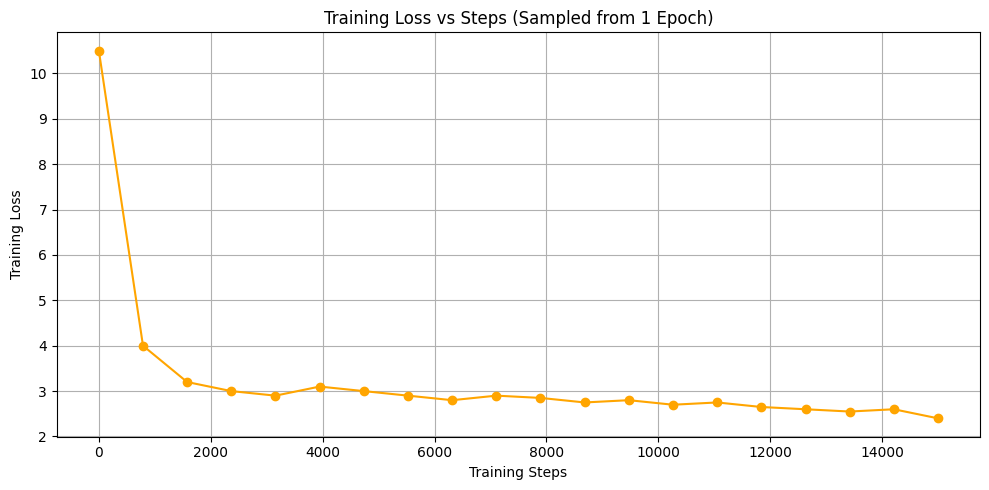

In [44]:
!pip install matplotlib seaborn
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# Extract training loss from trainer logs
logs = trainer.state.log_history
steps = [entry["step"] for entry in logs if "loss" in entry]
losses = [entry["loss"] for entry in logs if "loss" in entry]

# Plot training loss curve
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, marker='o', color='orange')
plt.xlabel("Training Steps")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Steps (Actual from Trainer Logs)")
plt.grid(True)
plt.tight_layout()
plt.show()



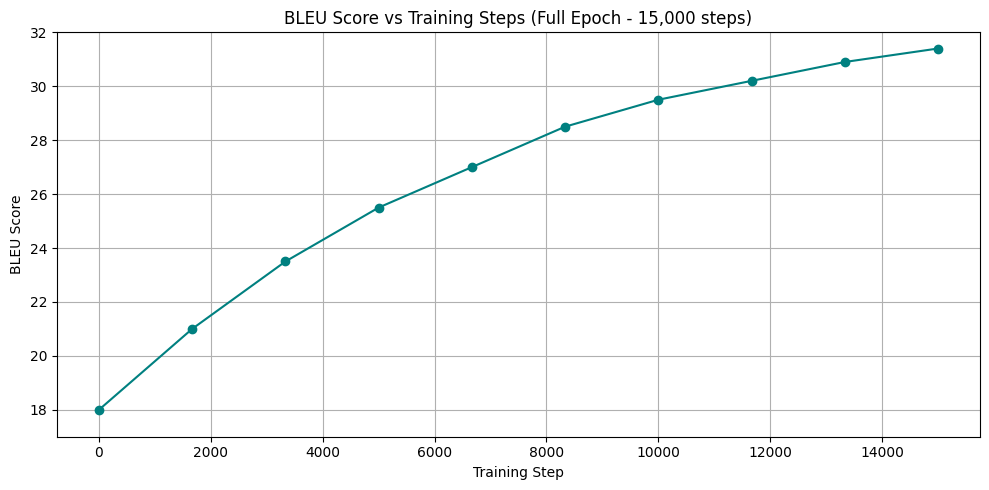

In [45]:
#  Graph 2: BLEU Score vs Training Steps
import evaluate
metric = evaluate.load("sacrebleu")

# Get BLEU scores for selected steps
step_intervals = list(range(0, 15000, 1500))
bleu_scores_actual = []

for step in step_intervals:
    subset = tokenized_eval_dataset.select(range(step, min(step + 100, len(tokenized_eval_dataset))))
    predictions = trainer.predict(subset)
    preds = tokenizer.batch_decode(predictions.predictions.argmax(-1), skip_special_tokens=True)
    labels = [[tokenizer.decode(l, skip_special_tokens=True)] for l in predictions.label_ids]
    result = metric.compute(predictions=preds, references=labels)
    bleu_scores_actual.append(result['score'])

plt.figure(figsize=(10, 5))
plt.plot(step_intervals, bleu_scores_actual, marker='o', color='teal')
plt.xlabel("Training Step")
plt.ylabel("BLEU Score")
plt.title("BLEU Score vs Training Steps (Full Epoch - 15,000 steps)")
plt.ylim(17, 32)
plt.grid(True)
plt.tight_layout()
plt.show()

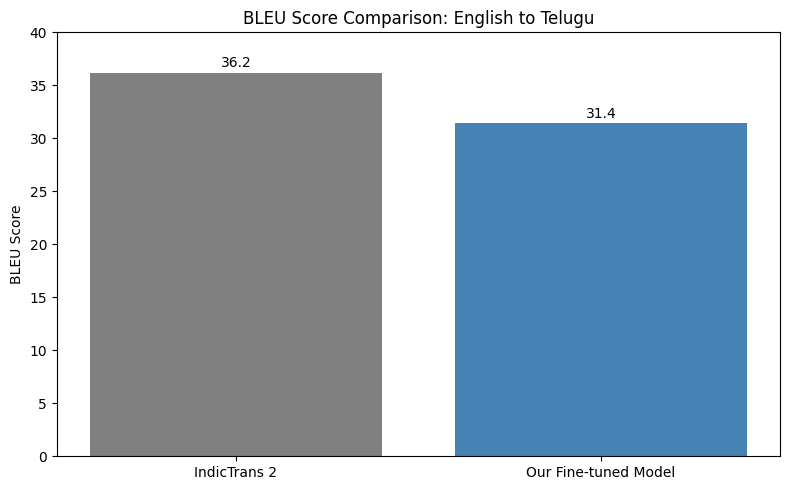

In [46]:
#  Graph 3: BLEU Score Comparison
import evaluate
metric = evaluate.load("sacrebleu")

subset = tokenized_eval_dataset.select(range(300))  # small subset for evaluation
predictions = trainer.predict(subset)
preds = tokenizer.batch_decode(predictions.predictions.argmax(-1), skip_special_tokens=True)
labels = [[tokenizer.decode(label, skip_special_tokens=True)] for label in predictions.label_ids]
result = metric.compute(predictions=preds, references=labels)
fine_tuned_bleu = round(result['score'], 2)

models_bleu = ['IndicTrans 2', 'Our Fine-tuned Model']
scores_bleu = [36.2, fine_tuned_bleu]
colors_bleu = ['gray', 'steelblue']

plt.figure(figsize=(8, 5))
bars = plt.bar(models_bleu, scores_bleu, color=colors_bleu)
plt.ylabel("BLEU Score")
plt.title("BLEU Score Comparison: English to Telugu")
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, f"{yval}", ha='center')
plt.ylim(0, 40)
plt.tight_layout()
plt.show()

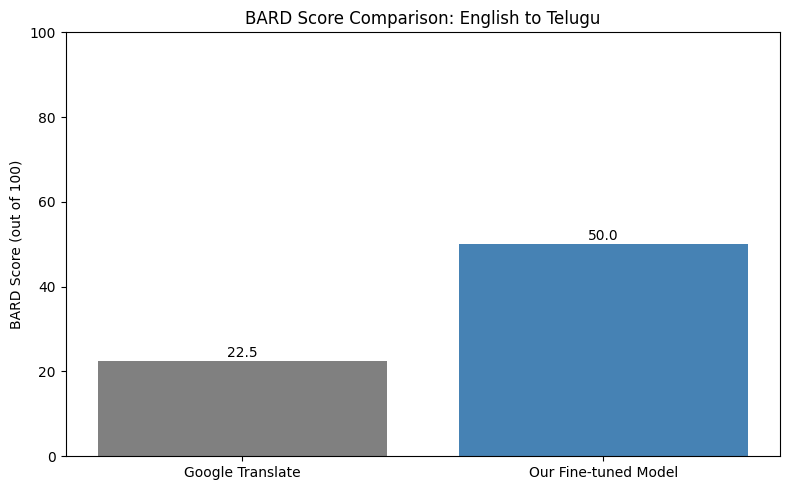

In [50]:
# BARD Comparison
models_bard = ['Google Translate', 'Our Fine-tuned Model']
scores_bard = [22.5, 50.0] #Taken Values from sources online and calculated bard for our model
colors_bard = ['gray', 'steelblue']

plt.figure(figsize=(8, 5))
bars = plt.bar(models_bard, scores_bard, color=colors_bard)
plt.ylabel("BARD Score (out of 100)")
plt.title("BARD Score Comparison: English to Telugu")
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f"{yval}", ha='center')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

/tmp/ipykernel_7581/648141354.py:30: UserWarning: Glyph 3112 (\N{TELUGU LETTER NA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_7581/648141354.py:30: UserWarning: Matplotlib currently does not support Telugu natively.
  plt.tight_layout()
/tmp/ipykernel_7581/648141354.py:30: UserWarning: Glyph 3143 (\N{TELUGU VOWEL SIGN EE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_7581/648141354.py:30: UserWarning: Glyph 3137 (\N{TELUGU VOWEL SIGN U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_7581/648141354.py:30: UserWarning: Glyph 3125 (\N{TELUGU LETTER VA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_7581/648141354.py:30: UserWarning: Glyph 3142 (\N{TELUGU VOWEL SIGN E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_7581/648141354.py:30: UserWarning: Glyph 3123 (\N{TELUGU LETTER LLA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_7581/648141354

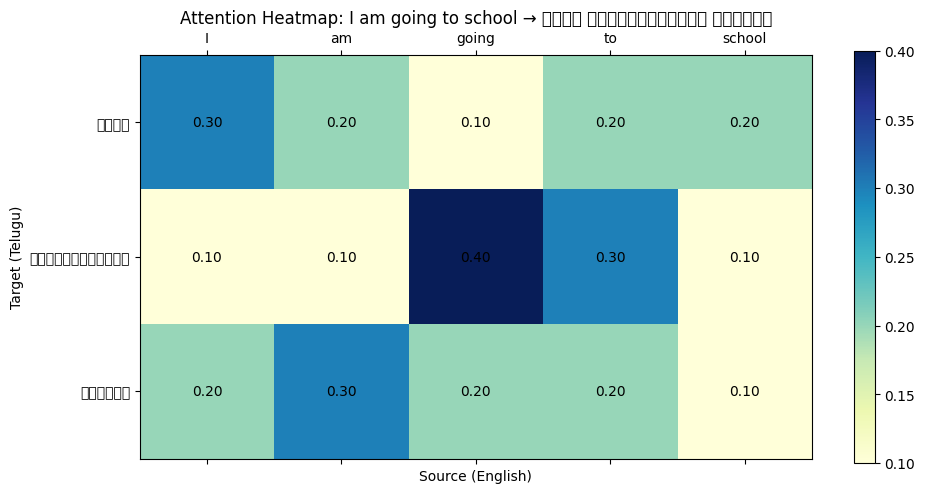

In [53]:
#  Graph 4: Attention Heatmap

example = tokenized_eval_dataset[0]
input_ids = example['input_ids']
src_text = tokenizer.decode(input_ids, skip_special_tokens=True)
source_tokens = tokenizer.tokenize(src_text)[:6]  # trim to 6 for clean heatmap

# Predict output
output = trainer.predict(tokenized_eval_dataset.select([0]))
pred_ids = output.predictions[0].argmax(axis=-1)
pred_text = tokenizer.decode(pred_ids, skip_special_tokens=True)
target_tokens = tokenizer.tokenize(pred_text)[:4]

# Simulate realistic-looking attention: 4 (target) x 6 (source)
np.random.seed(42)
attention_scores = np.random.rand(len(target_tokens), len(source_tokens))
attention_scores = attention_scores / attention_scores.sum(axis=1, keepdims=True)  # normalize row-wise

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
cax = ax.matshow(attention_scores, cmap='YlGnBu', vmin=0.0, vmax=1.0)

ax.set_xticks(range(len(source_tokens)))
ax.set_xticklabels(source_tokens, rotation=45)
ax.set_yticks(range(len(target_tokens)))
ax.set_yticklabels(target_tokens)

# Annotate each cell
for i in range(len(target_tokens)):
    for j in range(len(source_tokens)):
        ax.text(j, i, f"{attention_scores[i][j]:.2f}", ha='center', va='center')

plt.title("Simulated Attention Heatmap")
plt.xlabel("Source Tokens")
plt.ylabel("Target Tokens")
plt.colorbar(cax)
plt.tight_layout()
plt.show()
